<a href="https://colab.research.google.com/github/yoii18/KaggleModels/blob/main/IndianDiabetesDatabase_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# Common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import data

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Colab_Data/diabetes.csv", index_col=False)
data.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


# Feature Definitions:
1. `Pregnancies`: Number of times someone was pregnant
2. `Glucose`: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. `BloodPressure`: Diastolic blood pressure (mm Hg)
4. `SkinThickness`: Triceps skin fold thickness (mm)
5. `Insulin`: 2-Hour serum insulin (mu U/ml)
6. `BMI`: Body mass index (weight in kg/(height in m)^2)
7. `DiabetesPedigreeFunction`: Diabetes pedigree function
8. `Age`: Age (Years)
9. `Outcome`: Class variable (0 or 1) 268 of 768 are 1, the others are 0.


# Basic Information Gathering
We must gather some basic information regarding our dataset, this includes:
1. shape of our dataset
2. null values in our dataset
3. duplicate rows, if at all present
4. basic stats for both categorical and continuous features

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
data.shape

(768, 9)

In [6]:
cols = list(data.columns)
# print(cols)
for i, col in enumerate(cols):
  print(f"Unique values in {col}: ", data[col].nunique())
# print("Unique values")

Unique values in Pregnancies:  17
Unique values in Glucose:  136
Unique values in BloodPressure:  47
Unique values in SkinThickness:  51
Unique values in Insulin:  186
Unique values in BMI:  248
Unique values in DiabetesPedigreeFunction:  517
Unique values in Age:  52
Unique values in Outcome:  2


We have our target variable that is categorical, other than that, there seems to be no categorical variables

In [8]:
data.describe().T.iloc[:-1, 1:]

,mean,std,min,25%,50%,75%,max
Pregnancies,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


If we look at the stats carefully we see a lot of 0s at places where there shouldn't be any 0s, like glucose or blood pressure cannot be 0. So we replace these 0s with NaNs and later impute values into them

In [12]:
data_copy = data.copy(deep=True)
data_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data_copy[['Glucose','BloodPressure',
                                                                                    'SkinThickness','Insulin','BMI']].replace(0,np.nan)

In [14]:
cols = list(data_copy.columns)
# print(cols)
for i, col in enumerate(cols):
  print(f"NaN values in {col}: ", data_copy[col].isnull().sum())
# print("Unique values")

NaN values in Pregnancies:  0
NaN values in Glucose:  5
NaN values in BloodPressure:  35
NaN values in SkinThickness:  227
NaN values in Insulin:  374
NaN values in BMI:  11
NaN values in DiabetesPedigreeFunction:  0
NaN values in Age:  0
NaN values in Outcome:  0


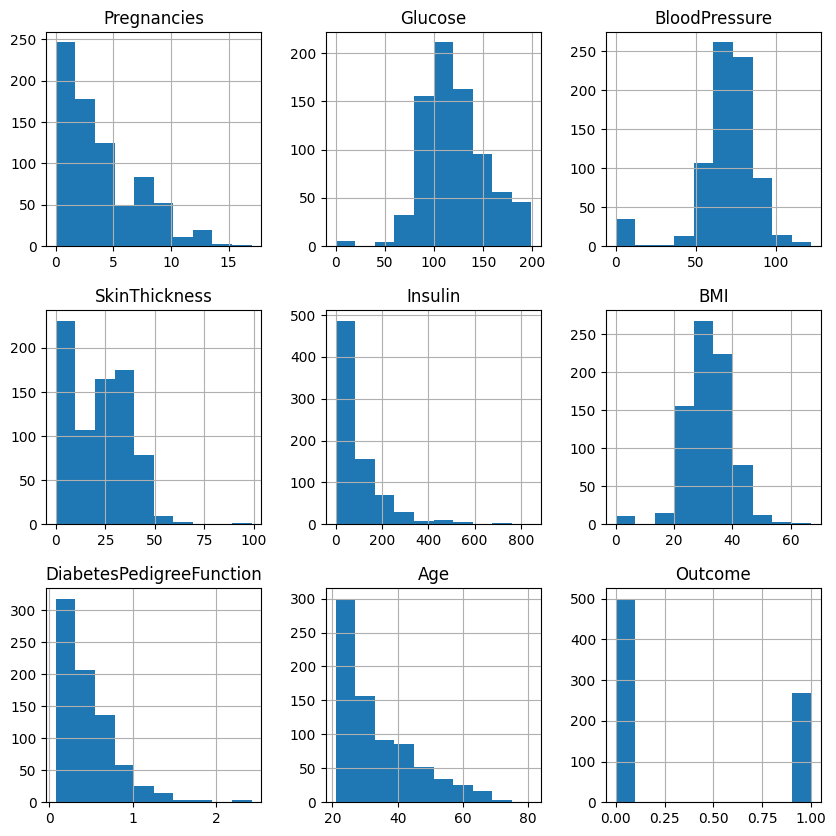

In [17]:
plot = data.hist(figsize=(10,10))

In [16]:
data_copy['Glucose'].fillna(data_copy['Glucose'].mean(), inplace=True)
data_copy['BloodPressure'].fillna(data_copy['BloodPressure'].mean(), inplace=True)
data_copy['SkinThickness'].fillna(data_copy['SkinThickness'].median(), inplace=True)
data_copy['Insulin'].fillna(data_copy['Insulin'].mean(), inplace=True)
data_copy['BMI'].fillna(data_copy['BMI'].mean(), inplace=True)

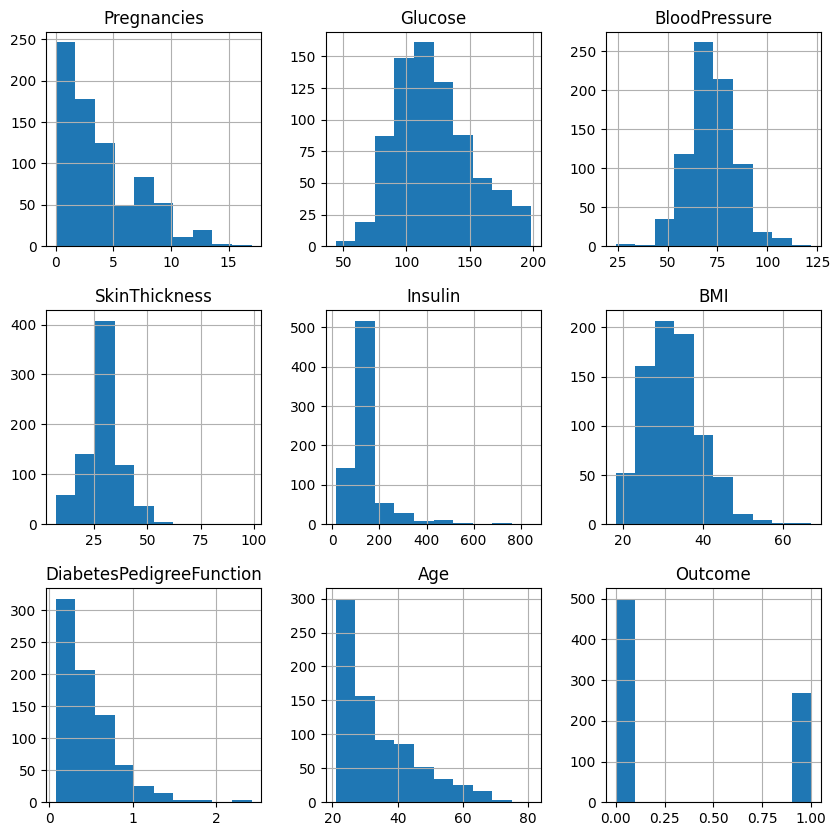

In [18]:
plot = data_copy.hist(figsize=(10,10))

In [19]:
cols = list(data_copy.columns)
# print(cols)
for i, col in enumerate(cols):
  print(f"Skewness of {col}: ", data_copy[col].skew())
# print("Unique values")

Skewness of Pregnancies:  0.9016739791518588
Skewness of Glucose:  0.5327186599872982
Skewness of BloodPressure:  0.13730536744146796
Skewness of SkinThickness:  0.8376083316006523
Skewness of Insulin:  3.019083661355125
Skewness of BMI:  0.5982526551146302
Skewness of DiabetesPedigreeFunction:  1.919911066307204
Skewness of Age:  1.1295967011444805
Skewness of Outcome:  0.635016643444986


In [23]:
cols = list(data_copy.columns)
# print(cols)
for i, col in enumerate(cols):
  print(f"Kurtosis of {col}: ", stats.kurtosis(data_copy[col]))
# print("Unique values")

Kurtosis of Pregnancies:  0.15038273760948462
Kurtosis of Glucose:  -0.2652767871408801
Kurtosis of BloodPressure:  1.082847367848931
Kurtosis of SkinThickness:  5.387891169923451
Kurtosis of Insulin:  15.078748264774752
Kurtosis of BMI:  0.9057125569396862
Kurtosis of DiabetesPedigreeFunction:  5.550792047551203
Kurtosis of Age:  0.6311769413798585
Kurtosis of Outcome:  -1.5983283582089547


Our data seems to have a lot of skewness and kurtosis. Which means that our data is far from a normal distribution.

# EDA

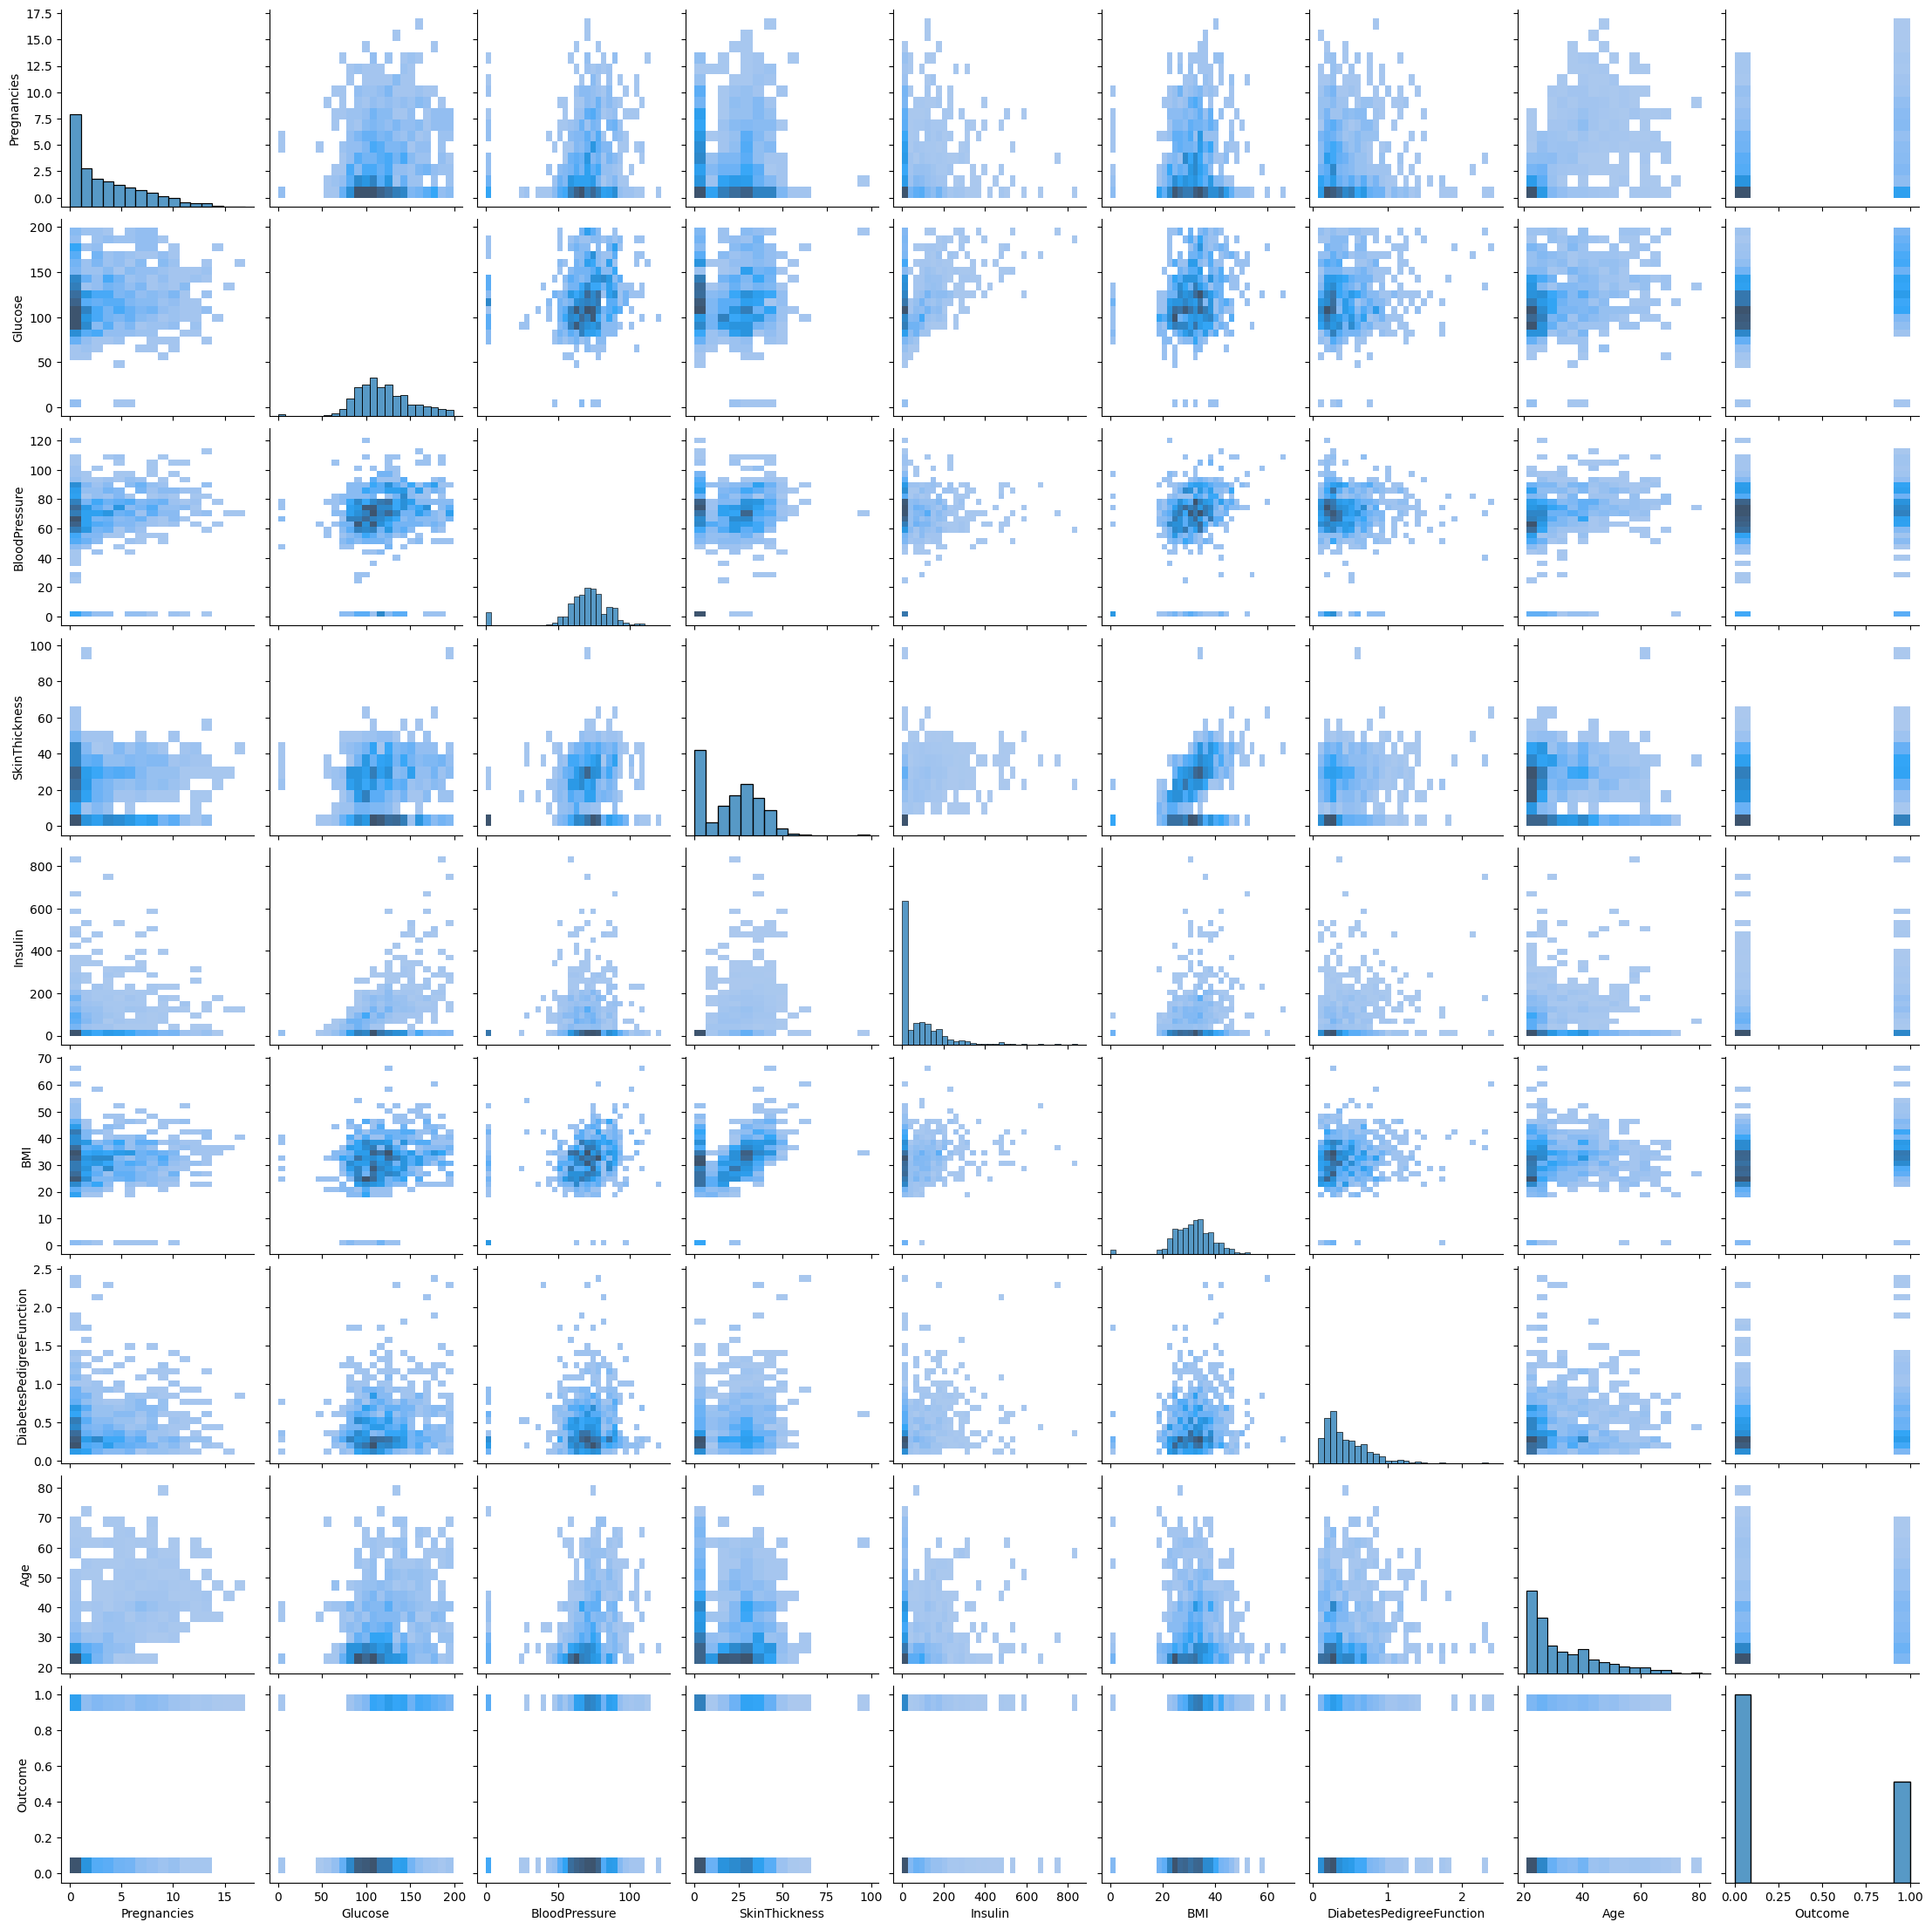

In [24]:
sns.pairplot(data, x_vars=cols, y_vars=cols, kind='hist')

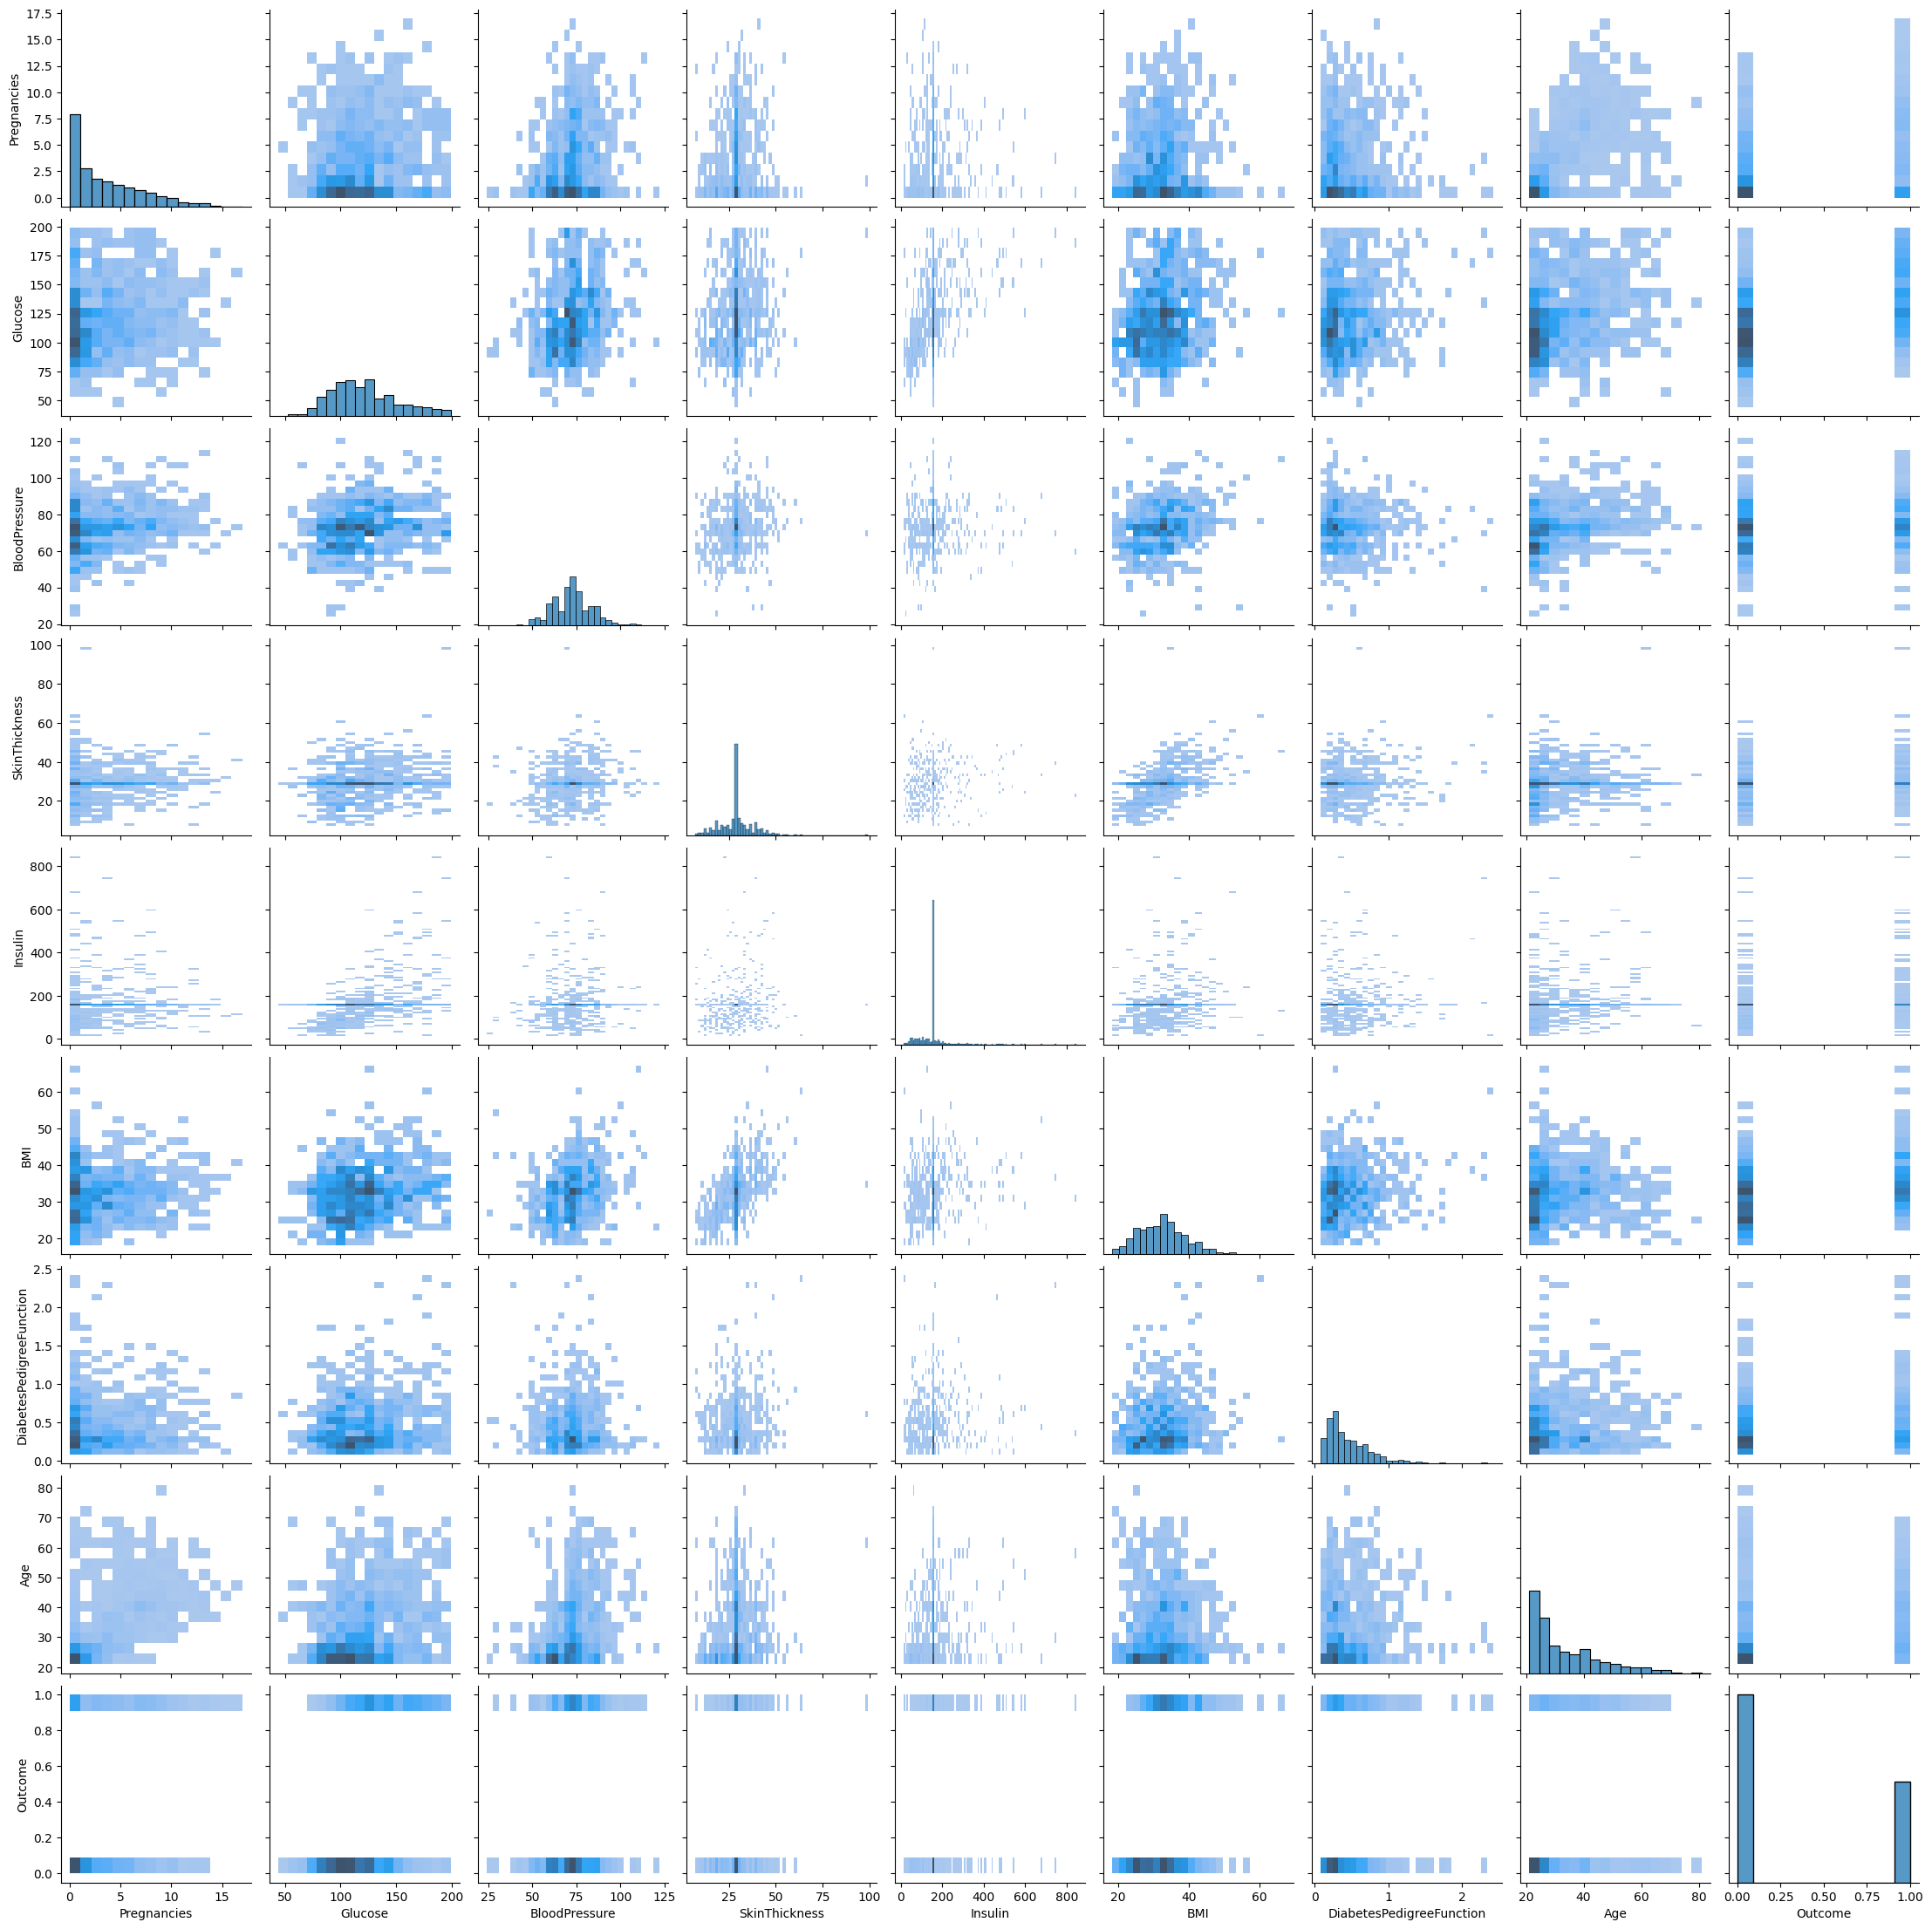

In [25]:
sns.pairplot(data_copy, x_vars=cols, y_vars=cols, kind='hist')

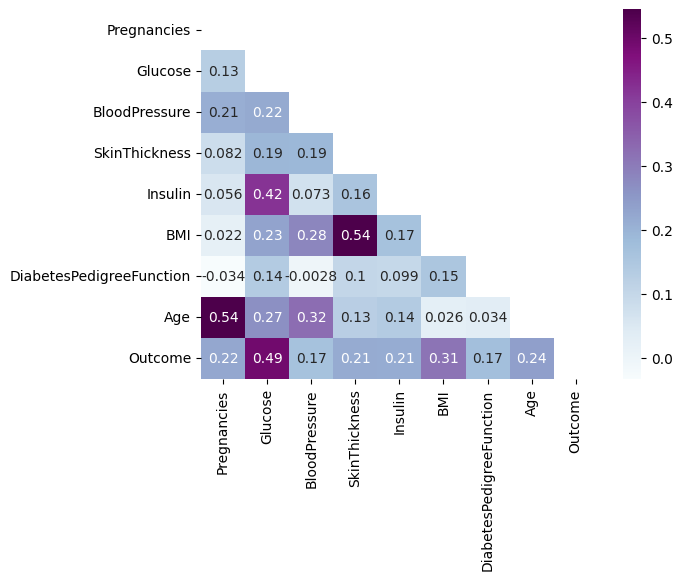

In [26]:
corr = data_copy.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, cmap='BuPu', annot=True)
plt.show()

In [29]:
cols = cols[:-1]
cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [30]:
sc_X = StandardScaler()
X =  pd.DataFrame(sc_X.fit_transform(data_copy.drop(["Outcome"],axis = 1),),
        columns=cols)

In [39]:
y = data_copy.Outcome

In [31]:
X.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865108,-0.033518,0.670643,-3.345079e-16,0.166292,0.468492,1.425995
1,-0.844885,-1.206162,-0.529859,-0.012301,-3.345079e-16,-0.852531,-0.365061,-0.190672


# Model

In [94]:
from sklearn.model_selection import train_test_split

# Splitting into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=42,
                                                    shuffle=True)

In [95]:
print(f"Shape of Training feature space: {X_train.shape}")
print(f"Shape of Training label space: {y_train.shape}")
print(f"Shape of Testing feature space: {X_test.shape}")
print(f"Shape of Testing label space: {y_test.shape}")

Shape of Training feature space: (514, 8)
Shape of Training label space: (514,)
Shape of Testing feature space: (254, 8)
Shape of Testing label space: (254,)


In [96]:
test_scores = []
train_scores = []
loss, bias, variance = [], [], []

for i in range(2,16):

    knn = KNeighborsClassifier(i)
    avg_expected_loss, avg_bias, avg_variance = bias_variance_decomp(knn,
                                                                     X_train.to_numpy(),
                                                                     y_train.to_numpy(),
                                                                     X_test.to_numpy(),
                                                                     y_test.to_numpy(),
                                                                     loss="0-1_loss")
    loss.append(avg_expected_loss)
    bias.append(avg_bias)
    variance.append(avg_variance)
    knn.fit(X_train,y_train)

    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [97]:
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 86.38132295719845 % and k = [2]


In [98]:
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 74.80314960629921 % and k = [12]


Text(0.5, 1.0, 'Train-Test Scores')

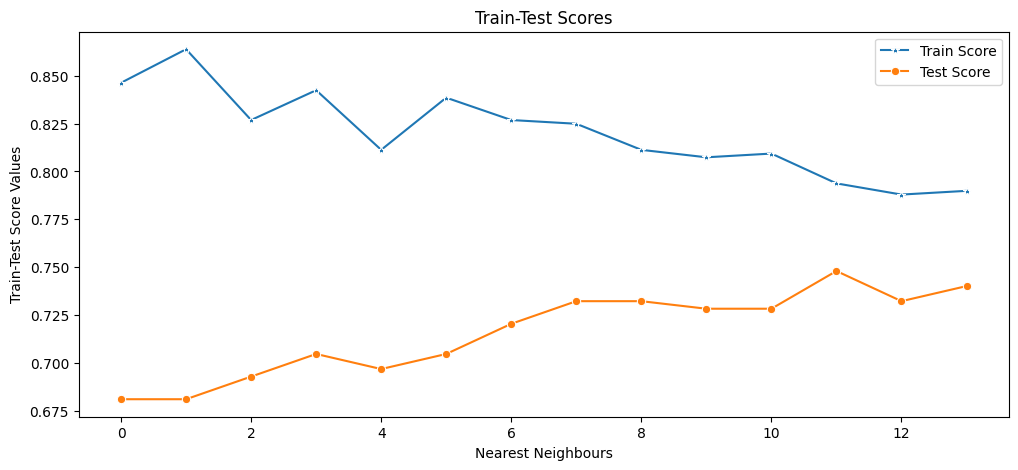

In [99]:
plt.figure(figsize=(12,5))
p = sns.lineplot(train_scores,marker='*',label='Train Score')
p = sns.lineplot(test_scores,marker='o',label='Test Score')
plt.xlabel("Nearest Neighbours")
plt.ylabel("Train-Test Score Values")
plt.title("Train-Test Scores")

Text(0.5, 1.0, 'Bias-Variance Breakdown (0-1 Loss)')

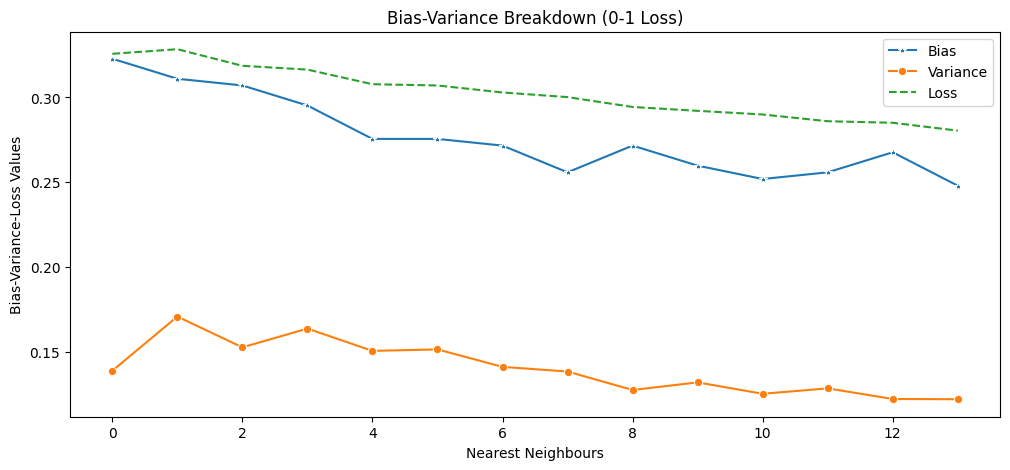

In [100]:
plt.figure(figsize=(12,5))
p = sns.lineplot(bias,marker='*',label='Bias')
p = sns.lineplot(variance,marker='o',label='Variance')
p = sns.lineplot(loss, linestyle='--', label='Loss')
plt.xlabel("Nearest Neighbours")
plt.ylabel("Bias-Variance-Loss Values")
plt.title("Bias-Variance Breakdown (0-1 Loss)")

In [101]:
knn = KNeighborsClassifier(12)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.7283464566929134

Text(0.5, 23.52222222222222, 'Predicted label')

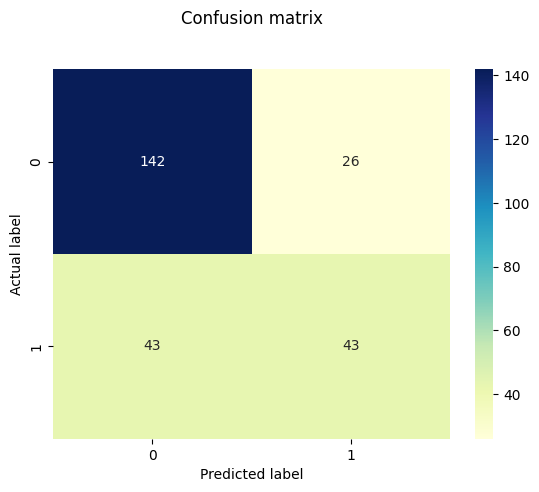

In [102]:
y_pred = knn.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [103]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.85      0.80       168
           1       0.62      0.50      0.55        86

    accuracy                           0.73       254
   macro avg       0.70      0.67      0.68       254
weighted avg       0.72      0.73      0.72       254



In [105]:
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)

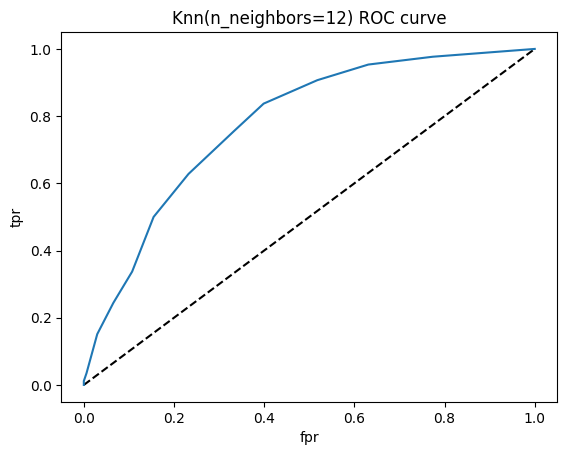

In [108]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=12) ROC curve')
plt.show()

In [107]:
metrics.roc_auc_score(y_test, y_pred_proba)

0.777720099667774